In [1]:
from sqlalchemy import create_engine
import pandas as pd
Server = 'LAPTOP-I7NEB9V3\SQLEXPRESS'
Database = 'Geopattern'
Driver = 'ODBC Driver 17 for SQL Server'
Database_Connection = f'mssql://@{Server}/{Database}?driver={Driver}'

engine = create_engine(Database_Connection)
connection = engine.connect()

df_original = pd.read_sql_query (
    "select * from OriginalData", connection)

df_original.reset_index(inplace = True)

import nltk
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer 

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy
from nltk.corpus import stopwords

import pyLDAvis
import pyLDAvis.gensim_models


import warnings
warnings.filterwarnings('ignore', category = DeprecationWarning)

import re

stop_words = stopwords.words('english')

import matplotlib.pyplot as plt


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\moham\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\moham\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
C:\Users\moham\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
df_LDA = df_original[['EID', 'Title' , 'Abstract']]
df_LDA.insert(3, 'Ttl_Abs','')
df_LDA.reset_index(inplace = True)
df_LDA = df_LDA.astype(str)

for i in df_LDA.index:
    df_LDA.loc[i, "Ttl_Abs"] = df_LDA.loc[i, "Title"] + '; ' + df_LDA.loc[i, "Abstract"]

In [3]:
texts_0 = df_LDA['Ttl_Abs']
# texts_0[20000]

In [4]:
# Remove punctuation

texts_1 = texts_0.map(lambda x: re.sub('[:;,\.!?]', '', x))
# texts_1[20000]

In [5]:
# Lowercase the words

texts_2 = texts_1.map(lambda x: x.lower())
# texts_2[20000]

In [6]:
# Lemmatize

def lemmatization(texts, allowed_postags = ["NOUN", "ADJ", "VERB", "ADV"]):
    nlp = spacy.load("en_core_web_sm", disable = ["parser", "ner"])
    texts_out = []
    for text in texts:
        doc = nlp(text)
        new_text = []
        for token in doc:
            if token.pos_ in allowed_postags:
                new_text.append(token.lemma_)
        final = " ".join(new_text)
        texts_out.append(final)
    return (texts_out)

texts_3 = lemmatization(texts_2)

# print (texts_3[20000])

In [7]:
# Stopwords

# stop_words.extend(['subject', 'paper', 'use', 'via', 'also', 'new', 'show', 'one', 'two' , 'via', 'result', 'can'])

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

# def remove_stopwords(texts):
#     return [[word for word in doc if word not in stop_words] for doc in texts]


texts_4 = remove_stopwords(texts_3)

# texts_4[20000]

In [ ]:
# # Tokenize

# def gen_words(texts):
#     final = []
#     for text in texts:
#         new = gensim.utils.simple_preprocess(text, deacc = True)
#         final.append(new)
#     return (final)

# texts_4 = gen_words(texts_3)

# texts_4[40000]

In [8]:
# BIGRAMS & TRIGRAMS

bigram_phrases = gensim.models.Phrases(texts_4, min_count = 5, threshold = 20)
trigram_phrases = gensim.models.Phrases(bigram_phrases[texts_4], threshold = 50)

bigram = gensim.models.phrases.Phraser(bigram_phrases)
trigram = gensim.models.phrases.Phraser(trigram_phrases)

def make_bigrams(texts):
    return([bigram[doc] for doc in texts])

def make_trigrams(texts):
    return ([trigram[bigram[doc]] for doc in texts])

data_bigrams = make_bigrams(texts_4)
data_bigrams_trigrams = make_trigrams(data_bigrams)

texts_5 = data_bigrams_trigrams

# print (texts_5[20000])

In [9]:
#TF-IDF REMOVAL

from gensim.models import TfidfModel

id2word = corpora.Dictionary(texts_5)

texts = texts_5

corpus = [id2word.doc2bow(text) for text in texts]
# print (corpus[0][0:20])

tfidf = TfidfModel(corpus, id2word=id2word)

low_value = 0.03
words  = []
words_missing_in_tfidf = []
for i in range(0, len(corpus)):
    bow = corpus[i]
    low_value_words = [] #reinitialize to be safe. You can skip this.
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    drops = low_value_words+words_missing_in_tfidf
    for item in drops:
        words.append(id2word[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf socre 0 will be missing

    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
    corpus[i] = new_bow

100%|██████████| 30/30 [3:13:01<00:00, 605.63s/it]  

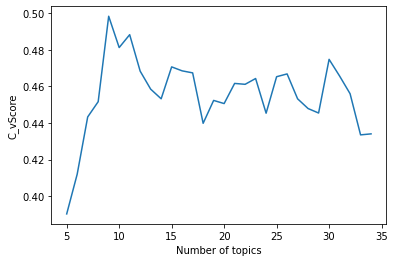

In [10]:
def compute_coherence_values(corpus, dictionary, k):
    
    lda_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k,
                                           chunksize = 100,
                                           passes = 10,
                                           random_state=100)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts_5, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

import numpy as np
import tqdm

grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 5
max_topics = 35
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Validation sets
num_of_docs = len(corpus)

model_results = {'Topics': [], 'Coherence': []}



pbar = tqdm.tqdm(total=len(topics_range))

for k in topics_range:
    cv = compute_coherence_values(corpus=corpus, dictionary=id2word, k=k)
    model_results['Topics'].append(k)
    model_results['Coherence'].append(cv)
    pbar.update(1)

    
x = model_results['Topics']
y = model_results['Coherence']

plt.xlabel('Number of topics')
plt.ylabel('C_vScore')


plt.plot(x,y)

In [21]:
print (max(model_results['Coherence']))
model_results['Coherence']
# model_results['Topics']

0.4982430848263748


[0.39032715678160007,
 0.4120191765631158,
 0.44326270301039034,
 0.4515995225677243,
 0.4982430848263748,
 0.4811476206067097,
 0.48817750747898886,
 0.46826820992500956,
 0.4584461380989437,
 0.453175696026715,
 0.4705973594903493,
 0.46842943445044294,
 0.46732578967384203,
 0.43979820613389276,
 0.4522876847073528,
 0.45057076623719194,
 0.4615684602682995,
 0.46108230402881606,
 0.4642427048199963,
 0.4453134814204705,
 0.46523084264373715,
 0.4667573506348303,
 0.4531698001808301,
 0.44785125954535415,
 0.44540909929699,
 0.47470873372745215,
 0.4656202350671859,
 0.4559584723906345,
 0.43348217066290734,
 0.4340264918439306]

In [18]:
lda_model = gensim.models.ldamulticore.LdaMulticore(corpus = corpus,
                                           id2word = id2word,
                                           num_topics = 9 ,
                                           random_state = 100,
                                           chunksize = 100,
                                           passes = 10)

In [19]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts_5, dictionary=id2word, coherence='c_v')

coherence_lda = coherence_model_lda.get_coherence()
print (coherence_lda)

cv = compute_coherence_values(corpus=corpus, dictionary=id2word, k=9)
print (cv)


0.5034445625247576
0.5004702817280293


In [22]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds = 'mmds', R = 20)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.040890 -0.074628       1        1  18.589547
4      0.164291  0.138281       2        1  16.420702
6     -0.026449  0.096206       3        1  14.186861
5     -0.016489 -0.263611       4        1  10.860442
0     -0.021533  0.335195       5        1  10.265815
7     -0.268358 -0.146936       6        1   9.413463
3     -0.338909  0.131162       7        1   8.593876
2      0.208145 -0.255146       8        1   6.204591
1      0.340192  0.039476       9        1   5.464703, topic_info=          Term          Freq         Total Category  logprob  loglift
24       model  46273.000000  46273.000000  Default  20.0000  20.0000
364      image  23298.000000  23298.000000  Default  19.0000  19.0000
23      method  32357.000000  32357.000000  Default  18.0000  18.0000
889    patient  12433.000000  12433.000000  Default  17.0000  17.0000
176  detection  12761.000000  12761.000000  Default  16.0000  16.0000
..         ...           ...           ...      ...      ...      ...
69        task   2294.133653   8167.263125   Topic9  -4.6627   1.6371
919    concept   1387.864647   3071.984481   Topic9  -5.1653   2.1123
632       term   1456.114914   4941.768693   Topic9  -5.1173   1.6849
67      system   2220.972102  27602.214015   Topic9  -4.6951   0.3869
124    extract   1183.232775   5734.412011   Topic9  -5.3248   1.3286

[454 rows x 6 columns], token_table=       Topic      Freq             Term
term                                   
2678       8  0.997375    accelerometer
388        1  0.601335         accuracy
388        4  0.139106         accuracy
388        6  0.071623         accuracy
388        7  0.118018         accuracy
...      ...       ...              ...
4555       3  0.996950  wireless_sensor
4976       7  0.998590            woman
818        9  0.999449             word
22970      1  0.996456   word_embedding
6720       5  0.998590            yeast

[1267 rows x 3 columns], R=20, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 5, 7, 6, 1, 8, 4, 3, 2])

In [23]:
vector = lda_model[corpus]
vector = list(vector)

In [27]:
tops = list(range(9))

for doc in vector:
    temp = []
    for top in doc:
        temp.append(top[0])
    z = [item for item in tops if item not in temp]
    for items in z:
        doc.append((items,0))

In [28]:
for i in vector:
    i.sort(key = lambda x: x[0])

In [82]:
i = 0
for doc in vector:
    df_LDA.loc[i,'topic_1'] = doc[0][1]
    df_LDA.loc[i,'topic_2'] = doc[1][1]
    df_LDA.loc[i,'topic_3'] = doc[2][1]
    df_LDA.loc[i,'topic_4'] = doc[3][1]
    df_LDA.loc[i,'topic_5'] = doc[4][1]
    df_LDA.loc[i,'topic_6'] = doc[5][1]
    df_LDA.loc[i,'topic_7'] = doc[6][1]
    df_LDA.loc[i,'topic_8'] = doc[7][1]
    df_LDA.loc[i,'topic_9'] = doc[8][1]
    i += 1


In [83]:
df_LDA.head(20)

,EID,Title,Abstract,Ttl_Abs,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,2-s2.0-84862560607,Finding density functionals with machine learning,Machine learning is used to approximate densit...,Finding density functionals with machine learn...,0.114249,0.000000,0.000000,0.000000,0.000000,0.000000,0.169574,0.138798,0.565117
1,2-s2.0-84862146412,On the evolution of component-based software,In a component-based software system the diffe...,On the evolution of component-based software; ...,0.000000,0.000000,0.000000,0.000000,0.981441,0.000000,0.000000,0.000000,0.000000
2,2-s2.0-84862141344,Query processing using negative and temporal t...,"In this paper, we analyze how stream monotonic...",Query processing using negative and temporal t...,0.000000,0.174268,0.000000,0.000000,0.000000,0.000000,0.641297,0.000000,0.169920
3,2-s2.0-84862490169,A two-step target binding and selectivity supp...,"Target selective drugs, such as dopamine recep...",A two-step target binding and selectivity supp...,0.581097,0.128296,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.284080
4,2-s2.0-84861980356,Detecting anomalies in netflow record time ser...,This paper presents current work for the detec...,Detecting anomalies in netflow record time ser...,0.128419,0.000000,0.321172,0.000000,0.000000,0.000000,0.209621,0.109599,0.217181
5,2-s2.0-84861744403,Generating possible interpretations for statis...,Statistics are very present in our daily lives...,Generating possible interpretations for statis...,0.000000,0.093609,0.000000,0.000000,0.640128,0.000000,0.000000,0.026641,0.231440
6,2-s2.0-84861990805,Network anomaly detection: Comparison and real...,This paper discusses several issues of evaluat...,Network anomaly detection: Comparison and real...,0.000000,0.026874,0.237060,0.000000,0.298132,0.000000,0.120635,0.000000,0.308579
7,2-s2.0-84861968614,Improving products' ergonomic value using inte...,During the process of defining suitable design...,Improving products' ergonomic value using inte...,0.000000,0.135072,0.000000,0.000000,0.841730,0.000000,0.000000,0.015331,0.000000
8,2-s2.0-84864938703,Automatic story segmentation for tv news video...,While video content is often stored in rather ...,Automatic story segmentation for tv news video...,0.000000,0.365138,0.099097,0.000000,0.092299,0.358163,0.000000,0.000000,0.080186
9,2-s2.0-84864914328,Forward-backward splitting methods for accreti...,Splitting methods have recently received much ...,Forward-backward splitting methods for accreti...,0.000000,0.000000,0.000000,0.000000,0.000000,0.039456,0.796860,0.000000,0.154660


In [84]:
df_LDA.to_csv(r'C:\Users\moham\Dropbox\QSE\Thesis\Geopattern\My data\df_LDA.csv')